In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct, Matern, RationalQuadratic, ExpSineSquared
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import random
from math import floor, ceil
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.inspection import permutation_importance

In [6]:
df_ml = pd.read_csv('8-11-23_cleaned_enthalpy_data_changed_fps_names.csv')
print(df_ml.shape)
print(df_ml.columns.tolist())
fp_columns = []
for col in df_ml.columns.tolist():
    if 'fp' in col:
        fp_columns.append(col)

(459, 261)
['Unnamed: 0', 'Unnamed: 0.1', '1/length', 'ID', 'roe_kj/mol', 'smiles_monomer', 'smiles_polymer', 'source', 'fp1', 'fp2', 'fp3', 'fp4', 'fp5', 'fp6', 'fp7', 'fp8', 'fp9', 'fp10', 'fp11', 'fp12', 'fp13', 'fp14', 'fp15', 'fp16', 'fp17', 'fp18', 'fp19', 'fp20', 'fp21', 'fp22', 'fp23', 'fp24', 'fp25', 'fp26', 'fp27', 'fp28', 'fp29', 'fp30', 'fp31', 'fp32', 'fp33', 'fp34', 'fp35', 'fp36', 'fp37', 'fp38', 'fp39', 'fp40', 'fp41', 'fp42', 'fp43', 'fp44', 'fp45', 'fp46', 'fp47', 'fp48', 'fp49', 'fp50', 'fp51', 'fp52', 'fp53', 'fp54', 'fp55', 'fp56', 'fp57', 'fp58', 'fp59', 'fp60', 'fp61', 'fp62', 'fp63', 'fp64', 'fp65', 'fp66', 'fp67', 'fp68', 'fp69', 'fp70', 'fp71', 'fp72', 'fp73', 'fp74', 'fp75', 'fp76', 'fp77', 'fp78', 'fp79', 'fp80', 'fp81', 'fp82', 'fp83', 'fp84', 'fp85', 'fp86', 'fp87', 'fp88', 'fp89', 'fp90', 'fp91', 'fp92', 'fp93', 'fp94', 'fp95', 'fp96', 'fp97', 'fp98', 'fp99', 'fp100', 'fp101', 'fp102', 'fp103', 'fp104', 'fp105', 'fp106', 'fp107', 'fp108', 'fp109', 'fp110'

Fitting 5 folds for each of 12 candidates, totalling 60 fits


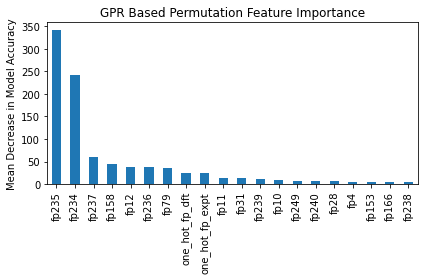

In [7]:
# using GPR with permutation feature importance now
x_for_fe = df_ml[fp_columns].to_numpy()
y_for_fe = df_ml['roe_kj/mol'].to_numpy()
cv = KFold(n_splits=5)
y_average = np.average(y_for_fe)
noise_estimate = np.std(y_for_fe)/3
kernel_noise = WhiteKernel(noise_level=(noise_estimate)*2, noise_level_bounds=((noise_estimate/4)**2, (noise_estimate*11)**2))
# define grid
grid = dict()
grid['kernel'] = [y_average**2*RationalQuadratic(length_scale=1)+kernel_noise, 
                  y_average**2*RBF(length_scale=1)+kernel_noise, 
                  y_average**2*Matern(length_scale=1)+kernel_noise]  # treating kernels as a hyperparameter
grid['alpha'] = [1e-10, 1e-5, 1e-2, 1e-1]  # this alpha parameter helps with fitting noise
model = GaussianProcessRegressor()

# define search
search = GridSearchCV(model, grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, verbose=1)
results = search.fit(x_for_fe, y_for_fe)
model = results.best_estimator_

# using permutation feature importance to see top 20 features
r = permutation_importance(model, x_for_fe, y_for_fe, n_repeats=10, scoring='neg_mean_squared_error')
important_count=0
importances = []
feature_names = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        importances.append(r.importances_mean[i])
        feature_names.append(fp_columns[i])
        important_count += 1
        if important_count == 80:
            break
gpr_importances_to_plot = pd.Series(importances[:20], index=feature_names[:20])  # only going to plot first 20
gpr_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
gpr_importances_to_plot.plot.bar(ax=ax)
ax.set_title("GPR Based Permutation Feature Importance")
ax.set_ylabel("Mean Decrease in Model Accuracy")
fig.tight_layout()
plt.show()

In [8]:
print(results.best_params_)
fp_columns = gpr_importances.index.tolist()
print(fp_columns)
print(len(fp_columns))

{'alpha': 0.1, 'kernel': 13.9**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=17.6)}
['fp235', 'fp234', 'fp237', 'fp158', 'fp12', 'fp236', 'fp79', 'one_hot_fp_dft', 'one_hot_fp_expt', 'fp11', 'fp31', 'fp239', 'fp10', 'fp249', 'fp240', 'fp28', 'fp4', 'fp153', 'fp166', 'fp238', 'fp133', 'fp34', 'fp96', 'fp90', 'fp149', 'fp46', 'fp35', 'fp58', 'fp247', 'fp126', 'fp154', 'fp233', 'fp132', 'fp97', 'fp188', 'fp200', 'fp152', 'fp151', 'fp175', 'fp107', 'fp156', 'fp212', 'fp30', 'fp27', 'fp198', 'fp199', 'fp182', 'fp214', 'fp80', 'fp204', 'fp219', 'cfp_one_hot_romp', 'fp32', 'fp230', 'fp53', 'fp125', 'fp76', 'fp98', 'fp101', 'fp111', 'fp23', 'fp82', 'fp102', 'fp120', 'fp202', 'fp95', 'fp7', 'fp124', 'fp190', 'fp146', 'fp213', 'fp112', 'fp57', 'fp222', 'fp15', 'fp121', 'fp20', 'fp108', 'fp73', 'fp245']
80


In [16]:
params = {'alpha': 0.01, 'kernel': 13.9**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=17.6)}
fp_columns_fe = ['fp235', 'fp234', 'fp237', 'fp79', 'fp158', 'fp12', 'fp236', '1/length', 'fp31', 'fp11', 
              'one_hot_fp_dft', 'one_hot_fp_expt', 'fp239', 'fp10', 'fp240', 'fp4', 'fp249', 'fp28', 'fp153', 
              'fp238', 'fp166', 'fp133', 'fp34', 'fp96', 'fp90', 'fp149', 'fp46', 'fp58', 'fp132', 'fp154', 
              'fp247', 'fp152', 'fp35', 'fp200', 'fp156', 'fp233', 'fp126', 'fp188', 'fp97', 'fp151', 'fp107', 
              'fp182', 'fp30', 'fp175', 'fp212', 'fp204', 'fp199', 'fp214', 'fp198', 'fp80']

In [10]:
# need to break the df into experimental data, DFT data, and loop3 only DFT data
dft_ids = set(df_ml[df_ml['source']=='dft']['ID'].tolist())
exp_ids = set(df_ml[df_ml['source']=='expt']['ID'].to_list())
exp_df = df_ml[df_ml['source']=='expt']
dft_df = df_ml[df_ml['source']=='dft']
loop3_only_IDs_exp, loop3_only_IDs_non_exp = [], []
for ex_id in df_ml[df_ml['1/length_non_normalized']==0.333]['ID'].unique():
    if df_ml[df_ml['ID']==ex_id].shape[0]<=2:
        if ex_id in exp_ids:
            loop3_only_IDs_exp.append(ex_id)
        else:
            loop3_only_IDs_non_exp.append(ex_id)
print(len(loop3_only_IDs_exp))
print(len(loop3_only_IDs_non_exp))

20
58


In [11]:
# need to filter out the ids which have multiple loop sizes for
for_learning_curve_ids = exp_ids.intersection(dft_ids)
print(len(for_learning_curve_ids))

68


In [12]:
# need to filter out the ids which have multiple loop sizes for
for_learning_curve_ids = exp_ids
print(len(for_learning_curve_ids))

109


In [13]:
# need to create exp and dft dfs which only have the IDs of interest
exp_df_lc = exp_df[exp_df['ID'].isin(for_learning_curve_ids)]
dft_df_lc = dft_df[dft_df['ID'].isin(for_learning_curve_ids)]
print(exp_df_lc.shape)

(109, 261)


In [14]:
for_learning_curve_ids = set(exp_df_lc['ID'].tolist())

In [17]:
# creating data for plotting in learning curves for all cases
rmse_avgs_case_0, rmse_avgs_case_1, rmse_avgs_case_2, rmse_avgs_case_3 = [], [], [], []
rmse_stds_case_0, rmse_stds_case_1, rmse_stds_case_2, rmse_stds_case_3 = [], [], [], []
all_rmses_case_0, all_rmses_case_1, all_rmses_case_2, all_rmses_case_3 = [], [], [], []
all_rmses_case_0_train, all_rmses_case_1_train, all_rmses_case_2_train, all_rmses_case_3_train = [], [], [], []
sample_sizes = [x/100 for x in range(10,100, 10)]
# sample_sizes.append(0.999)
x_for_learning_curve = []
for sample_size in sample_sizes:
#     print(sample_size)
    for i in range(100):  # taking 100 samples to get statistics
        x_for_learning_curve.append(sample_size)
        sample_IDs = random.sample(for_learning_curve_ids, floor(sample_size*len(for_learning_curve_ids)))
        # all test dfs will be the same for the different cases
        # print(len(sample_IDs))
        test_df = exp_df_lc[~exp_df_lc['ID'].isin(sample_IDs)]
#         if test_df.shape[0]==0:
#             print('ERROR: ', set(for_learning_curve_ids)-set(sample_IDs))
        test_IDs = set(test_df['ID'].tolist())
        x_test = test_df[fp_columns_fe]
        y_test = test_df['roe_kj/mol']
        
        # case 0
        train_df = exp_df_lc[exp_df_lc['ID'].isin(sample_IDs)]
        x_train = train_df[fp_columns_fe]
        y_train = train_df['roe_kj/mol']
        model = GaussianProcessRegressor(**params)
        model.fit(x_train, y_train)
        prediction, sigma = model.predict(x_test, return_std=True)
        prediction_train, sigma_train = model.predict(x_train, return_std=True)
        rmses = mean_squared_error(y_test, prediction, squared=False)
        rmses_train = mean_squared_error(y_train, prediction_train, squared=False)
        all_rmses_case_0.append(np.mean(rmses))
        all_rmses_case_0_train.append(np.mean(rmses_train))
        # current_uncertainty_case_0.append(np.mean(sigma))
#         print('case 0: ', x_train.shape, x_test.shape)
        
        # case 1
        # create correct train data
        train_df = pd.concat([train_df, dft_df_lc[dft_df_lc['ID'].isin(sample_IDs)]])
        x_train = train_df[fp_columns_fe]
        y_train = train_df['roe_kj/mol']
        # train model
        model = GaussianProcessRegressor(**params)
        model.fit(x_train, y_train)
        # predictions and store metrics
        prediction, sigma = model.predict(x_test, return_std=True)
        prediction_train, sigma_train = model.predict(x_train, return_std=True)
        rmses = mean_squared_error(y_test, prediction, squared=False)
        rmses_train = mean_squared_error(y_train, prediction_train, squared=False)
        all_rmses_case_1.append(np.mean(rmses))
        all_rmses_case_1_train.append(np.mean(rmses_train))
        # current_uncertainty_case_1.append(np.mean(sigma))
#         print('case 1: ', x_train.shape, x_test.shape)
        
        # case 2
        # create correct train data
        train_df = pd.concat([train_df, dft_df_lc[(dft_df_lc['ID'].isin(test_IDs))&(dft_df_lc['1/length_non_normalized']==0.333)]])
        x_train = train_df[fp_columns_fe]
        y_train = train_df['roe_kj/mol']
        # train model
        model = GaussianProcessRegressor(**params)
        model.fit(x_train, y_train)
        # predictions and store metrics
        prediction, sigma = model.predict(x_test, return_std=True)
        prediction_train, sigma_train = model.predict(x_train, return_std=True)
        rmses = mean_squared_error(y_test, prediction, squared=False)
        rmses_train = mean_squared_error(y_train, prediction_train, squared=False)
        all_rmses_case_2.append(np.mean(rmses))
        all_rmses_case_2_train.append(np.mean(rmses_train))
        # current_uncertainty_case_2.append(np.mean(sigma))
#         print('case 2: ', x_train.shape, x_test.shape)
        
        # case 3
        # create correct train data
        train_df = pd.concat([train_df, dft_df_lc[(dft_df_lc['ID'].isin(test_IDs))&(dft_df_lc['1/length_non_normalized']!=0.333)]])
        x_train = train_df[fp_columns_fe]
        y_train = train_df['roe_kj/mol']
        # train model
        model = GaussianProcessRegressor(**params)
        model.fit(x_train, y_train)
        # predictions and store metrics
        prediction, sigma = model.predict(x_test, return_std=True)
        prediction_train, sigma_train = model.predict(x_train, return_std=True)
        rmses = mean_squared_error(y_test, prediction, squared=False)
        rmses_train = mean_squared_error(y_train, prediction_train, squared=False)
        all_rmses_case_3.append(np.mean(rmses))
        all_rmses_case_3_train.append(np.mean(rmses_train))
        # current_uncertainty_case_3.append(np.mean(sigma))
#         print('case 3: ', x_train.shape, x_test.shape)
        # making sure I have no data saving issue
        del train_df, test_df
        
        # break
    
#     print('--------------')


In [18]:
# print(rmse_avgs_case_0)
# print(rmse_avgs_case_1)
# print(rmse_avgs_case_2)
print(len(all_rmses_case_3), len(all_rmses_case_3_train))
# Creating data frame to visualize using seaborn
learning_curve_df = pd.concat([
    pd.DataFrame({'sample size': x_for_learning_curve, 'RMSE (KJ/mol)': all_rmses_case_0, 'case': ['ST']*len(all_rmses_case_0), 'type': ['test']*len(all_rmses_case_0)}),
    pd.DataFrame({'sample size': x_for_learning_curve, 'RMSE (KJ/mol)': all_rmses_case_1, 'case': ['MT1']*len(all_rmses_case_0), 'type': ['test']*len(all_rmses_case_0)}),
    pd.DataFrame({'sample size': x_for_learning_curve, 'RMSE (KJ/mol)': all_rmses_case_2, 'case': ['MT2']*len(all_rmses_case_0), 'type': ['test']*len(all_rmses_case_0)}),
    pd.DataFrame({'sample size': x_for_learning_curve, 'RMSE (KJ/mol)': all_rmses_case_3, 'case': ['MT3']*len(all_rmses_case_0), 'type': ['test']*len(all_rmses_case_0)}),
    pd.DataFrame({'sample size': x_for_learning_curve, 'RMSE (KJ/mol)': all_rmses_case_0_train, 'case': ['ST']*len(all_rmses_case_0_train), 'type': ['train']*len(all_rmses_case_0_train)}),
    pd.DataFrame({'sample size': x_for_learning_curve, 'RMSE (KJ/mol)': all_rmses_case_1_train, 'case': ['MT1']*len(all_rmses_case_0_train), 'type': ['train']*len(all_rmses_case_0_train)}),
    pd.DataFrame({'sample size': x_for_learning_curve, 'RMSE (KJ/mol)': all_rmses_case_2_train, 'case': ['MT2']*len(all_rmses_case_0_train), 'type': ['train']*len(all_rmses_case_0_train)}),
    pd.DataFrame({'sample size': x_for_learning_curve, 'RMSE (KJ/mol)': all_rmses_case_3_train, 'case': ['MT3']*len(all_rmses_case_0_train), 'type': ['train']*len(all_rmses_case_0_train)})
])
learning_curve_df.reset_index(drop=True, inplace=True)

900 900


In [19]:
def correct_case_name(case):
    if case == 'case 0':
        return 'ST'
    if case == 'case 1':
        return 'MT1'
    if case == 'case 2':
        return 'MT2'
    if case == 'case 3':
        return 'MT3'

In [20]:
loocv_df = pd.read_csv('23-8-24_loocv_results_for_learning_curve.csv')
loocv_df['case'] = loocv_df['case'].apply(correct_case_name)
print(loocv_df['case'].unique())
loocv_df['sample size'] = [0.999]*loocv_df.shape[0]
# dropping indices where I have test LOOCV data and then concatenating the dfs
indices_to_drop = learning_curve_df[(learning_curve_df['sample size']==0.999)&(learning_curve_df['type']=='test')].index.tolist()
learning_curve_df.drop(index=indices_to_drop, inplace=True)
learning_curve_df = pd.concat([learning_curve_df, loocv_df])
learning_curve_df.reset_index(inplace=True, drop=True)

['ST' 'MT1' 'MT2' 'MT3']


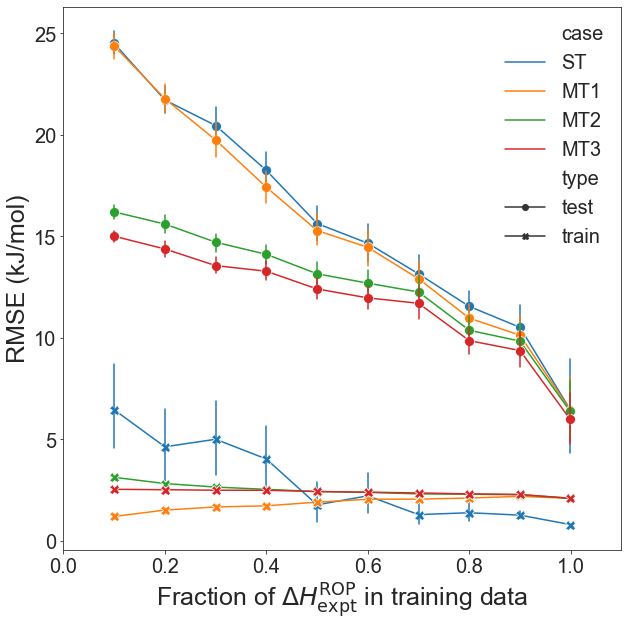

In [21]:
fig = plt.gcf()
fig.set_size_inches(10,10)

sns.set_style(style='white')
sns.set_style('ticks')
# plt.style.use('science')
ax = sns.lineplot(
    data=learning_curve_df, x="sample size", y="RMSE (KJ/mol)", hue="case", style='type', err_style='bars', markers=True, 
    dashes=False, ms=10
)
plt.legend(loc='upper right', fontsize=20, frameon=False)
ax.set_xlabel("Fraction of $\Delta H^{\mathrm{ROP}}_{\mathrm{expt}}$ in training data", fontsize=25)
ax.set_ylabel("RMSE (kJ/mol)", fontsize=25)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
# ax.set_ylim([0,22])
ax.set_xlim([0, 1.1])
# sns.scatterplot(data=learning_curve_df, x="sample size", y="rmse", s=100)
fig.savefig('../../paper_writing/first_enthalpy_ml_paper/figures/23-10-18_enthalpy_learning_curve_correct_loocv.pdf')